# Spectral Clustering for Image Segmentation

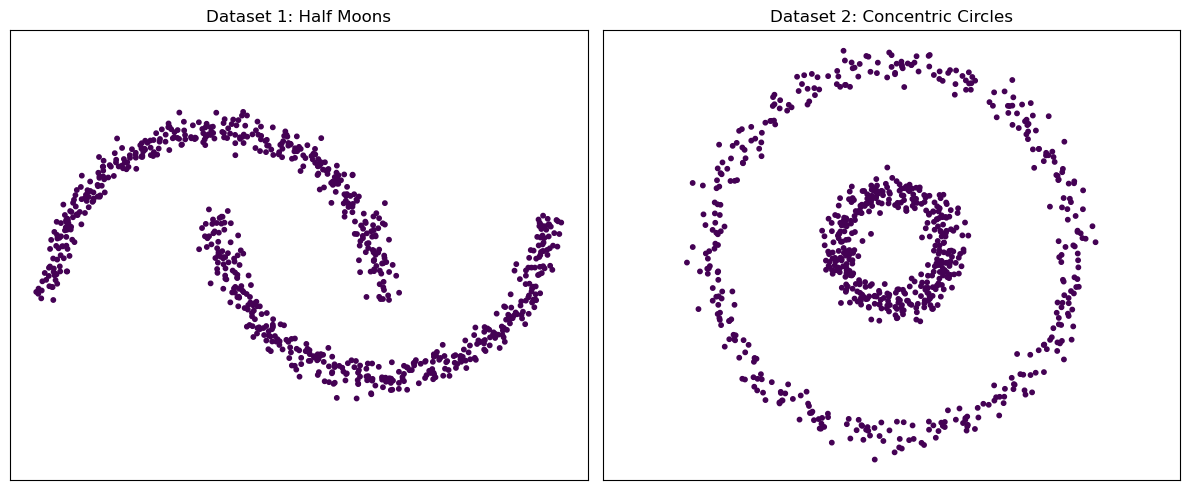

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.linalg import pinv, eigh
from sklearn.datasets import make_moons, make_circles
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import pairwise_distances, adjusted_rand_score
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import StandardScaler

n_samples = 800
random_state = 42

X_moons, y_moons = make_moons(n_samples=n_samples, noise=0.05, random_state=random_state)
X_circles, y_circles = make_circles(n_samples=n_samples, factor=0.3, noise=0.05, random_state=random_state)

def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis')
    plt.title(title)
    plt.axis('equal')
    plt.xticks([])
    plt.yticks([])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_clusters(X_moons, np.zeros(n_samples), "Dataset 1: Half Moons")
plt.subplot(1, 2, 2)
plot_clusters(X_circles, np.zeros(n_samples), "Dataset 2: Concentric Circles")
plt.tight_layout()
plt.show()

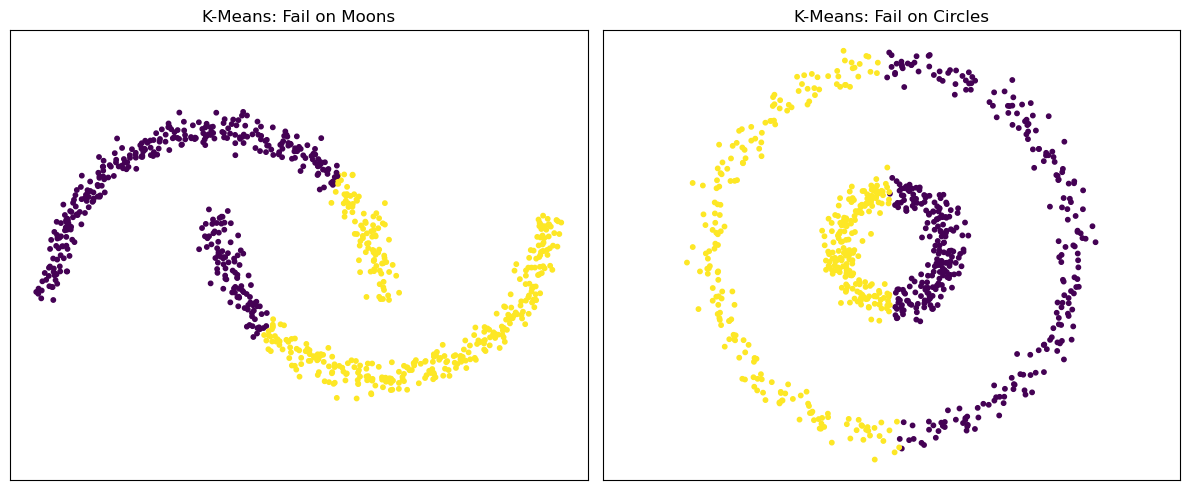

In [2]:
kmeans_moons = KMeans(n_clusters=2, random_state=random_state).fit(X_moons)
kmeans_circles = KMeans(n_clusters=2, random_state=random_state).fit(X_circles)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_clusters(X_moons, kmeans_moons.labels_, "K-Means: Fail on Moons")
plt.subplot(1, 2, 2)
plot_clusters(X_circles, kmeans_circles.labels_, "K-Means: Fail on Circles")
plt.tight_layout()
plt.show()

--- Dataset: Circles ---


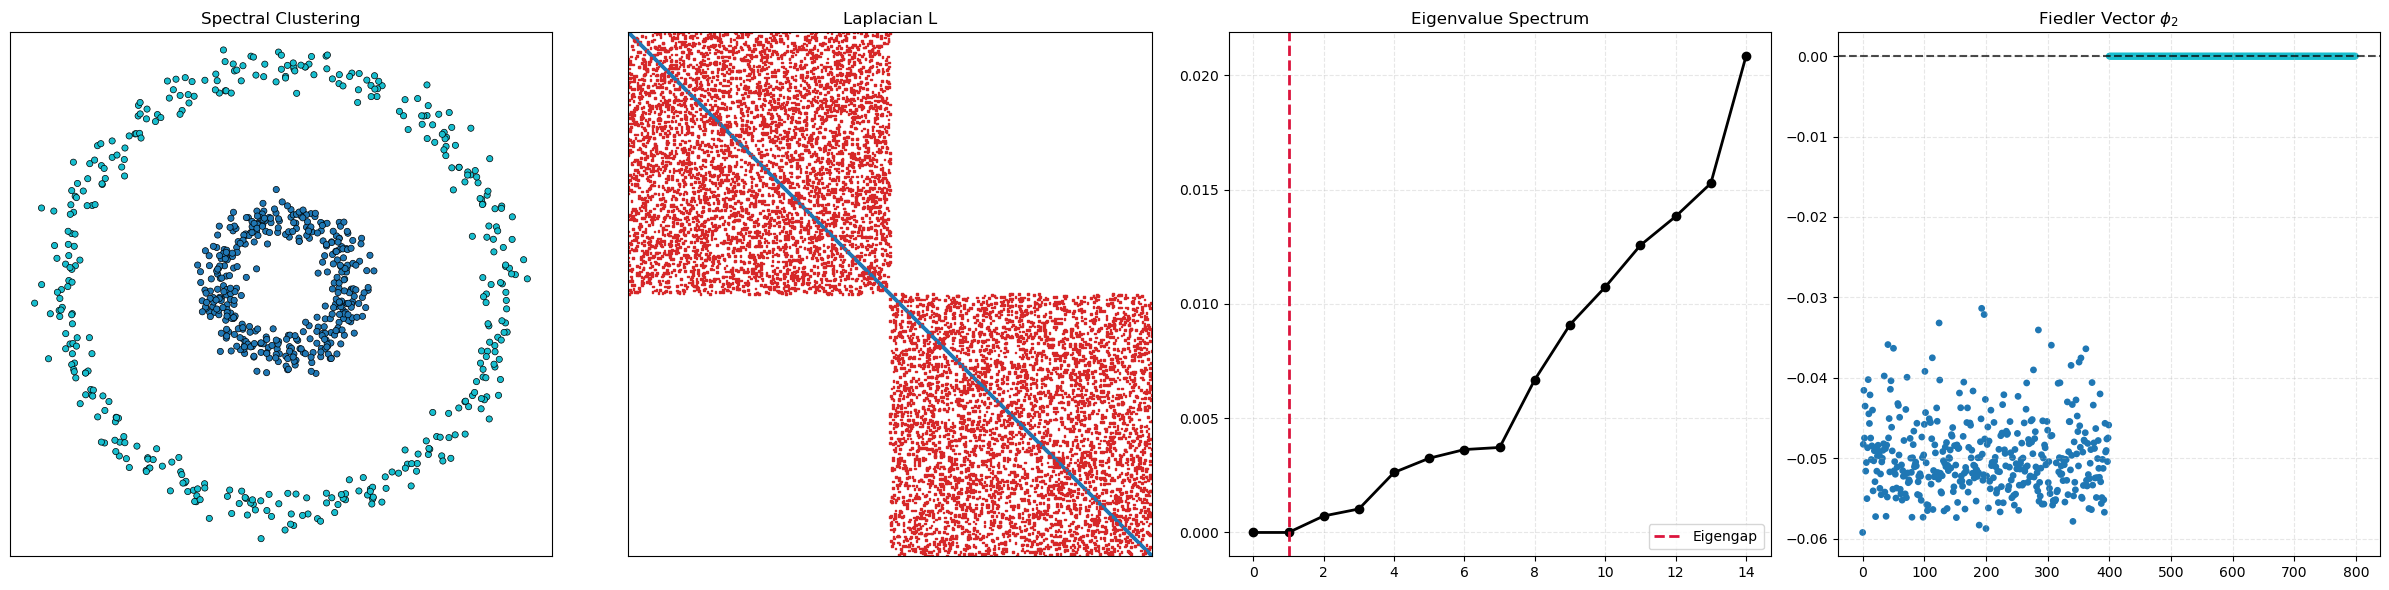

--- Dataset: Moons ---


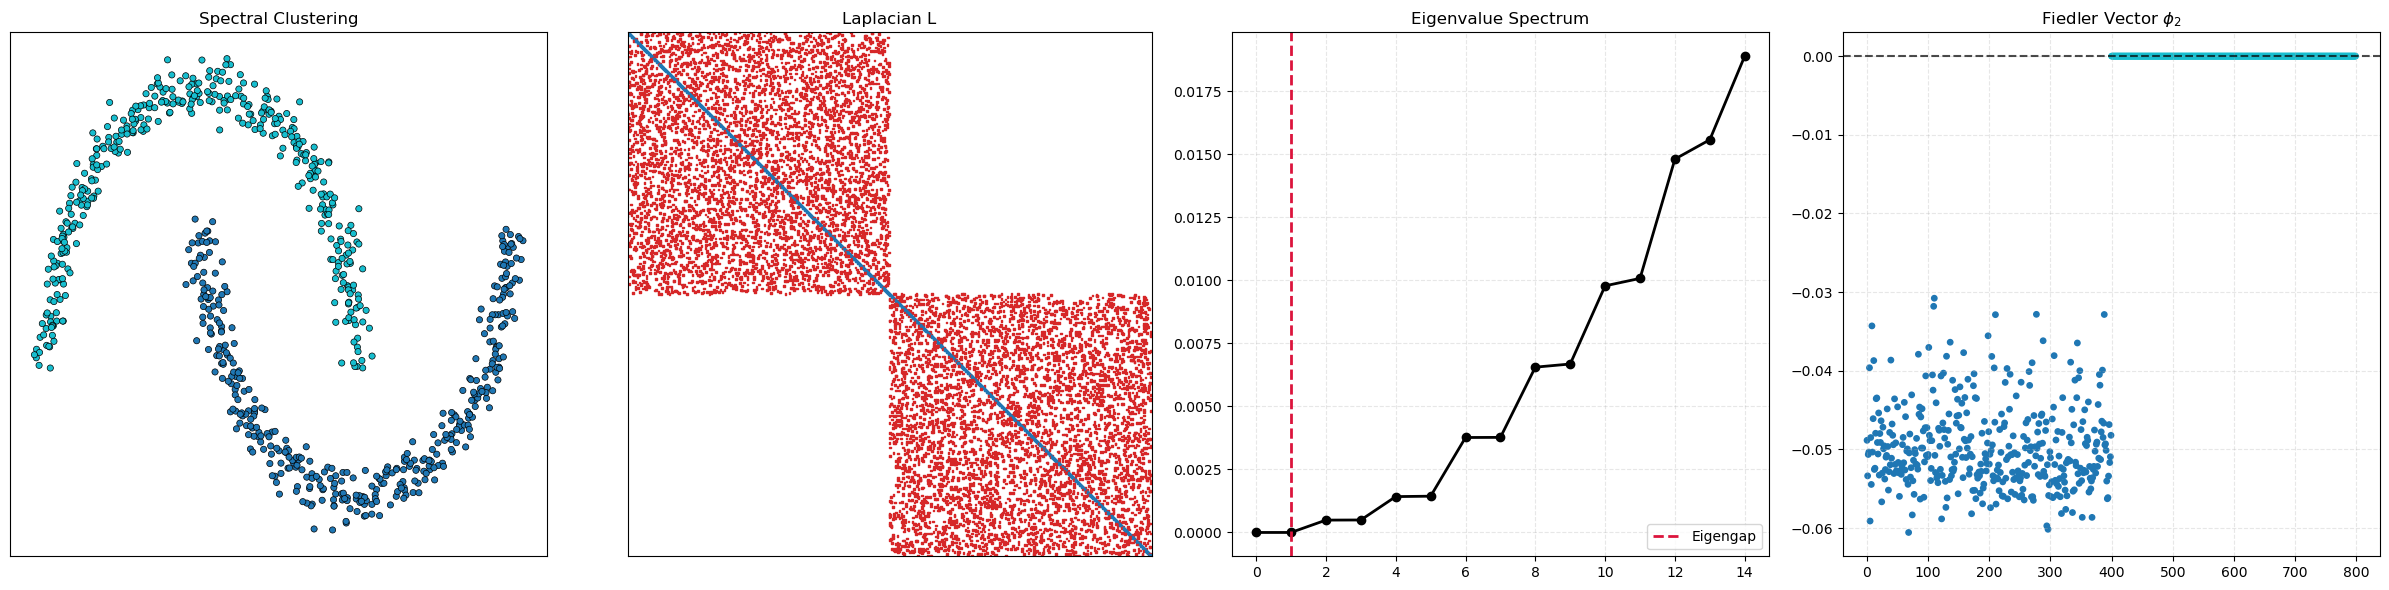

In [3]:
def spectral_clustering_dense(X, n_clusters=2, k_nn=10, plot_results=True):
    N = X.shape[0]

    # 1. Costruzione Grafo (Kernel Adattivo KNN)
    dists = pairwise_distances(X)
    nbrs = NearestNeighbors(n_neighbors=k_nn + 1).fit(X)
    distances, indices = nbrs.kneighbors(X)
    sigma = np.median(distances[:, 1:], axis=1)  
    
    W = np.exp(-(dists ** 2) / (sigma[:, None] * sigma[None, :]))
    W_knn = np.zeros_like(W)
    for i in range(N):
        W_knn[i, indices[i]] = W[i, indices[i]]
        
    W = np.maximum(W_knn, W_knn.T)
    np.fill_diagonal(W, 0)
    
    # 2. Laplaciano Normalizzato
    d = np.sum(W, axis=1)
    d_inv_sqrt = np.zeros_like(d)
    d_inv_sqrt[d > 0] = 1.0 / np.sqrt(d[d > 0])
    D_inv_sqrt = np.diag(d_inv_sqrt)
    L = np.eye(N) - D_inv_sqrt @ W @ D_inv_sqrt
    
    # 3. Decomposizione Spettrale
    eigenvals, eigenvecs = np.linalg.eigh(L)
    idx = np.argsort(eigenvals)
    eigenvals = eigenvals[idx]
    eigenvecs = eigenvecs[:, idx]
    
    # 4. Clustering (Ng-Jordan-Weiss)
    U = eigenvecs[:, :n_clusters]
    U_norm = U / np.linalg.norm(U, axis=1, keepdims=True)
    labels = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit_predict(U_norm)
    
    if plot_results:
        sort_idx = np.argsort(labels)
        fiedler_vec = eigenvecs[:, 1]
        L_sorted = L[sort_idx][:, sort_idx]
        
        fig, axes = plt.subplots(1, 4, figsize=(24, 6))
        
        axes[0].scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', s=20, edgecolors='k', linewidth=0.5)
        axes[0].set_title("Spectral Clustering")
        axes[0].set_xticks([]); axes[0].set_yticks([])
        axes[0].axis('equal')
        
        rows_L, cols_L = np.where(np.abs(L_sorted) > 0)
        vals_L = L_sorted[rows_L, cols_L]

        colors_L = ['#d62728' if v < 0 else '#1f77b4' for v in vals_L] 
        
        axes[1].scatter(cols_L, rows_L, c=colors_L, s=1.5, marker='s')
        axes[1].set_xlim(0, N); axes[1].set_ylim(N, 0)
        axes[1].set_aspect('equal')
        axes[1].set_title("Laplacian L")
        axes[1].set_xticks([]); axes[1].set_yticks([])
        
        axes[2].plot(eigenvals[:15], 'o-', color='black', linewidth=2, markersize=6)
        axes[2].axvline(x=n_clusters-1, color='crimson', linestyle='--', linewidth=2, label='Eigengap')
        axes[2].set_title("Eigenvalue Spectrum")
        axes[2].grid(True, alpha=0.3, linestyle='--')
        axes[2].legend()
        
        axes[3].scatter(range(N), fiedler_vec[sort_idx], c=labels[sort_idx], cmap='tab10', s=15)
        axes[3].axhline(y=0, color='k', ls='--', alpha=0.7)  
        axes[3].set_title("Fiedler Vector $\phi_2$")
        axes[3].grid(True, alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.show()
    
    return labels
    
scaler = StandardScaler() 
X_moons_std = scaler.fit_transform(X_moons) 
X_circles_std = scaler.fit_transform(X_circles)

print("--- Dataset: Circles ---")
_ = spectral_clustering_dense(X_circles_std, n_clusters=2, k_nn=10)

print("--- Dataset: Moons ---")
_ = spectral_clustering_dense(X_moons_std, n_clusters=2, k_nn=10)

--- Dataset: Circles ---


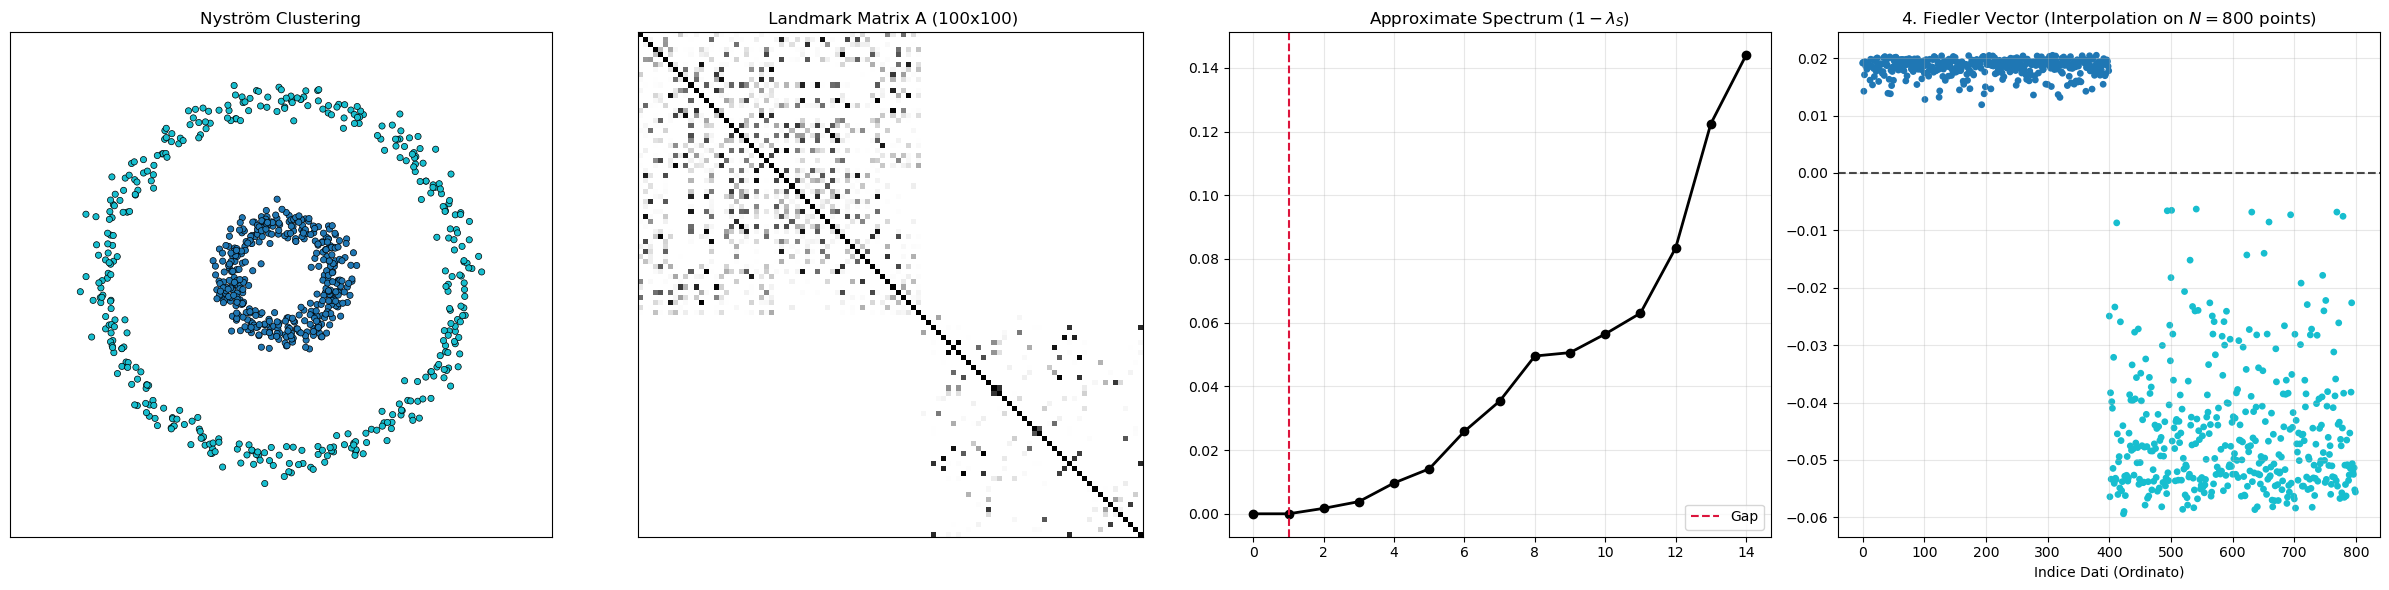

--- Dataset: Moons ---


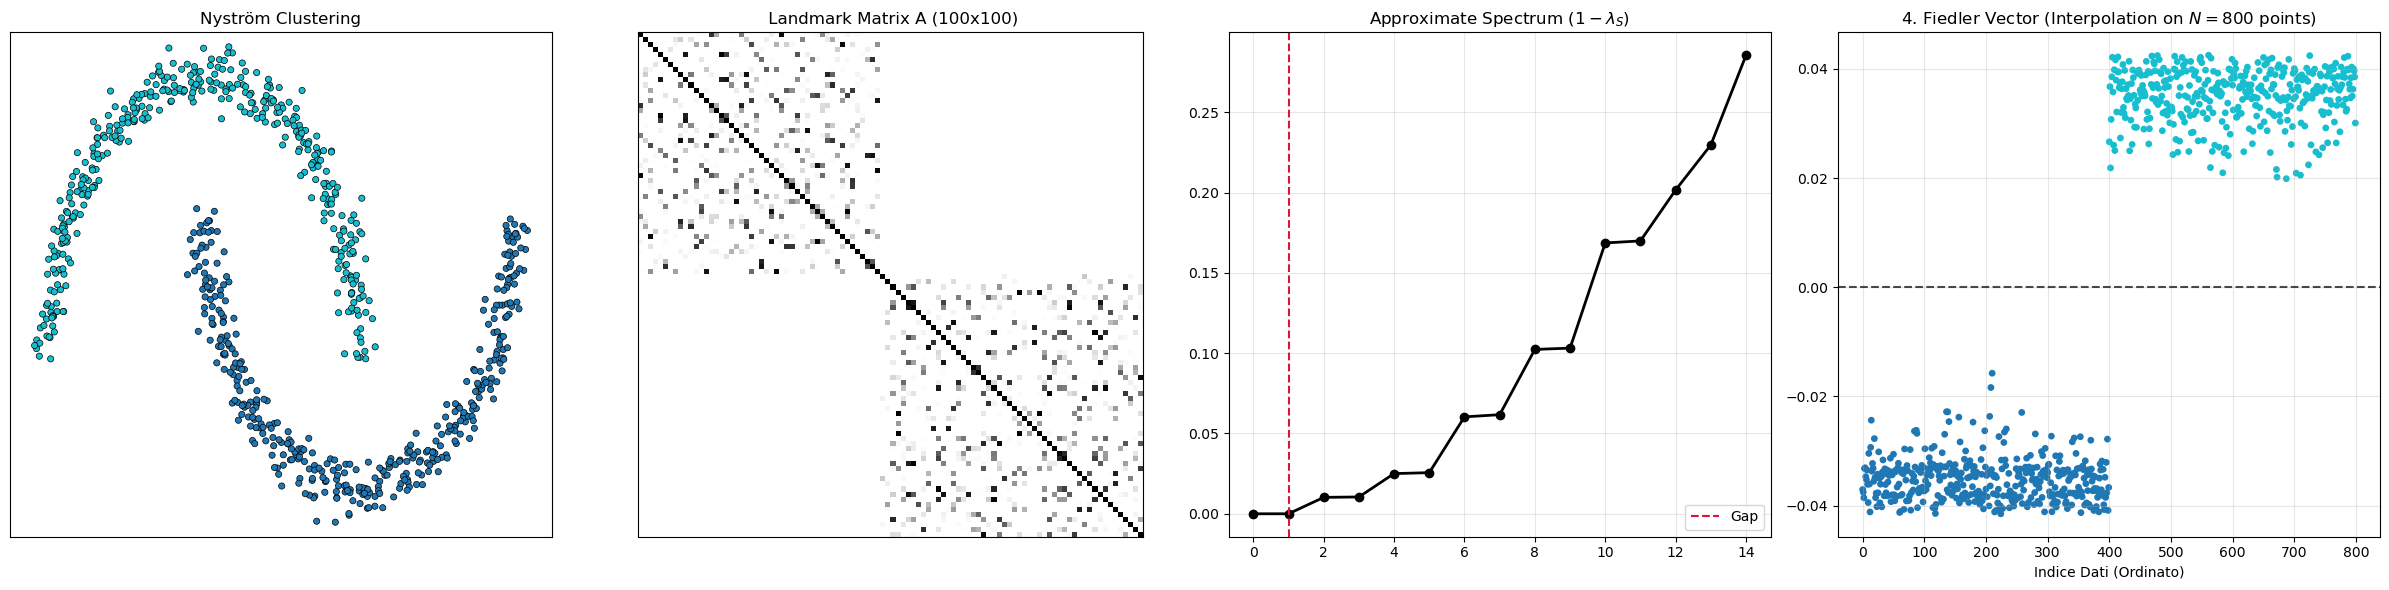

In [4]:
def nystrom_spectral_clustering(X, n_clusters, m=100, gamma=15.0, plot_results=True):
    N = X.shape[0]
    
    # 1. Campionamento Landmark
    inds = np.random.choice(N, m, replace=False)
    X_land = X[inds]
    X_rest = X[~np.isin(np.arange(N), inds)]
    
    # Kernel RBF
    A = rbf_kernel(X_land, X_land, gamma=gamma)
    B = rbf_kernel(X_rest, X_land, gamma=gamma)

    # 2. Normalizzazione Gradi (Fowlkes-Belongie)
    col_sum_B = np.sum(B, axis=0)
    d_land = np.sum(A, axis=1) + col_sum_B
    d_rest = np.sum(B, axis=1) + B @ np.linalg.solve(A + 1e-8*np.eye(m), np.sum(B, axis=0))

    
    d_all = np.concatenate([d_land, d_rest])
    inv_sqrt_d = 1.0 / np.sqrt(d_all + 1e-10)
    
    A_norm = A * np.outer(inv_sqrt_d[:m], inv_sqrt_d[:m])
    B_norm = B * np.outer(inv_sqrt_d[m:], inv_sqrt_d[:m])

    # 3. Ortogonalizzazione
    vals_A, U_A = eigh(A_norm)
    mask_pos = vals_A > 1e-10
    vals_A_sqrt_inv = np.zeros_like(vals_A)
    vals_A_sqrt_inv[mask_pos] = 1.0 / np.sqrt(vals_A[mask_pos])
    A_sqrt_inv = U_A @ np.diag(vals_A_sqrt_inv) @ U_A.T

    # Matrice S (Core Approximation)
    S = A_norm + (B_norm @ A_sqrt_inv).T @ (B_norm @ A_sqrt_inv)
    
    # Calcoliamo TUTTI gli autovalori di S per vedere lo spettro completo dell'approssimazione
    vals_S, U_S = eigh(S)
    
    # Ordinamento per importanza (dal più grande al più piccolo per Kernel Matrix)
    idx_all = np.argsort(vals_S)[::-1]
    vals_S_sorted = vals_S[idx_all]
    U_S_sorted = U_S[:, idx_all]

    # Prendiamo solo i top k per il clustering
    vals_S_k = vals_S_sorted[:n_clusters]
    U_S_k = U_S_sorted[:, :n_clusters]

    # 4. Estensione di Nyström
    V = np.vstack([A_norm, B_norm]) @ A_sqrt_inv @ U_S_k @ np.diag(1.0/np.sqrt(vals_S_k))

    # 5. Clustering
    V_final = V / np.linalg.norm(V, axis=1, keepdims=True)
    
    # K-Means sui vettori riordinati
    labels_unordered = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit_predict(V_final)
    
    # Ricostruzione ordine originale
    labels = np.zeros(N)
    labels[inds] = labels_unordered[:m]
    labels[~np.isin(np.arange(N), inds)] = labels_unordered[m:]
    
    if plot_results:
        V_ordered = np.zeros((N, n_clusters))
        V_ordered[inds] = V[:m]
        V_ordered[~np.isin(np.arange(N), inds)] = V[m:]
        
        sort_idx = np.argsort(labels)
        
        labels_land = labels[inds]
        sort_idx_land = np.argsort(labels_land)
        
        fig, axes = plt.subplots(1, 4, figsize=(24, 6))
        
        axes[0].scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', s=20, edgecolors='k', linewidth=0.5)
        axes[0].set_title("Nyström Clustering")
        axes[0].axis('equal')
        axes[0].set_xticks([]); axes[0].set_yticks([])

        axes[1].imshow(A[sort_idx_land][:, sort_idx_land], cmap='Greys', interpolation='nearest')
        axes[1].set_title(f" Landmark Matrix A ({m}x{m})")
        axes[1].set_xticks([]); axes[1].set_yticks([])

        # PLOT 3: Spettro Approssimato
        # Convertiamo autovalori di similarità in "Laplacian-like" (1 - lambda) per confronto visivo
        approx_laplacian_eigs = 1 - vals_S_sorted
        approx_laplacian_eigs = np.sort(approx_laplacian_eigs)
        
        axes[2].plot(approx_laplacian_eigs[:15], 'o-', color='black', linewidth=2, markersize=6)
        axes[2].axvline(x=n_clusters-1, color='crimson', linestyle='--', label='Gap')
        axes[2].set_title("Approximate Spectrum ($1 - \lambda_S$)")
        axes[2].grid(True, alpha=0.3)
        axes[2].legend()
        
        fiedler_approx = V_ordered[:, 1][sort_idx]
        axes[3].scatter(range(N), fiedler_approx, c=labels[sort_idx], cmap='tab10', s=15)
        axes[3].axhline(y=0, color='k', ls='--', alpha=0.7)
        axes[3].set_title("4. Fiedler Vector (Interpolation on $N=800$ points)")
        axes[3].set_xlabel("Indice Dati (Ordinato)")
        axes[3].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return labels

print("--- Dataset: Circles ---")
_ = nystrom_spectral_clustering(X_circles_std, n_clusters=2, m=100, gamma=15.0)

print("--- Dataset: Moons ---")
_ = nystrom_spectral_clustering(X_moons_std, n_clusters=2, m=100, gamma=15.0)

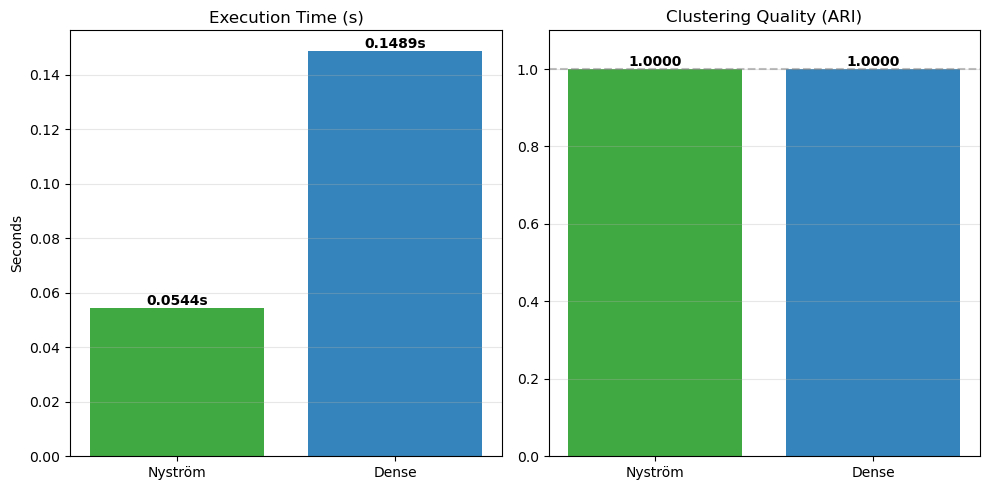

In [6]:
k = 2
m = 100
gamma = 15.0
k_nn = 10

t0 = time.time()
labels_nys = nystrom_spectral_clustering(X_circles_std, n_clusters=k, m=m, gamma=gamma, plot_results=False)
t_nys = time.time() - t0
ari_nys = adjusted_rand_score(y_circles, labels_nys)

t0 = time.time()
labels_dense = spectral_clustering_dense(X_circles_std, n_clusters=k, k_nn=k_nn, plot_results=False)
t_dense = time.time() - t0
ari_dense = adjusted_rand_score(y_circles, labels_dense)

methods = ["Nyström", "Dense"]
times = [t_nys, t_dense]
aris = [ari_nys, ari_dense]
colors = ['#2ca02c', '#1f77b4']  

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

bars1 = axes[0].bar(methods, times, color=colors, alpha=0.9)
axes[0].set_title("Execution Time (s)")
axes[0].set_ylabel("Seconds")
axes[0].grid(axis="y", alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}s', ha='center', va='bottom', fontweight='bold')

bars2 = axes[1].bar(methods, aris, color=colors, alpha=0.9)
axes[1].set_title("Clustering Quality (ARI)")
axes[1].set_ylim(0, 1.1)
axes[1].axhline(1.0, color='gray', linestyle='--', alpha=0.5)
axes[1].grid(axis="y", alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()
